# In this tutorial we are going to use CellChat, which is available here: https://github.com/sqjin/CellChat

In [15]:
library(CellChat)
library(patchwork)
library(magrittr)
options(stringsAsFactors = FALSE)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



# Load Data

First, we load the output from the Seurat workflow

In [5]:
data <- readRDS('seurat_pbmc3k.rds')

We are going to use the normalized data as the gene expression matrix for CellChat (stored in ```data@assays$RNA@data```)

In [6]:
data.input <- data@assays$RNA@data

**Inspecting the metadata**

Let's explore the metadata slot (```data@meta.data```) and print out the first 5 elements

In [10]:
head(data@meta.data, n=5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters,celltype
,<fct>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,2,2,Memory CD4 T
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,3,3,B
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,2,2,Memory CD4 T
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,1,1,CD14+ Mono
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,6,6,NK


Store the metadata dataframe in a new variable for calling it later

In [9]:
meta <- data@meta.data

# Inferring cell-cell communication from gene expression

This kind of analyses have been previously reviewed here: https://www.nature.com/articles/s41576-020-00292-x

The general workflow that most of the current tools/methods use is described in Figure 2a.

Here, we use that figure and specify the main commands for each of the steps that CellChat has:

![plot](./Workflow.png)

**Briefly:**
- Steps 1-2 involve generating the dataset, aligning reads to generate count matrix and preprocess it.
- Then, the preprocessed expression matrix is used as output of CellChat (functions ```createCellChat```. ```addMeta()``` and ```setIdent()```)
- For step 3, CellChat includes a built-in database of Ligand-Receptor pairs (variable ```CellChatDB.human``` for humans and ```CellChatDB.mouse``` for mice)
- In step 4, the gene expression matrix is filtered by the list of LR pairs with ```subsetData()```
- Thus, a communication score can be inferred for each LR pair given the expression of both the ligand and the receptor. Several scoring functions exist for this step, and the one that CellChat uses can be found here: https://www.nature.com/articles/s41467-021-21246-9
- In step 5, the communication score for each LR pair in a given sender-receiver cell pair is computed with ```computeCommunProb()```. Similarly, CellChat offers computing an score for Signaling Pathways (encompassing multiple LR pairs) with ```computeCommunProbPathway()```
- For studying overall communication, we can aggregate these scores with: ```aggregateNet()```
- Once we have these main results, different visualization options can be used for interpreting the results, as indicated in Step 6. For this, CellChat offers multiple visualizations, which are specified in section III of the following tutorial: https://htmlpreview.github.io/?https://github.com/sqjin/CellChat/blob/master/tutorial/CellChat-vignette.html

## Perform step 2 of cell-cell communication workflow

**Create CellChat object**

In [12]:
cells <- rownames(meta)[meta$orig.ident == "pbmc3k"]

In [16]:
cellchat <- createCellChat(object = data.input[, cells],
                           meta = meta[cells, ],
                           group.by = "celltype")

Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  Naive CD4 T CD14+ Mono Memory CD4 T B CD8 T FCGR3A+ Mono NK DC Platelet 


**Add metadata into metaslot of the objects**

In [18]:
cellchat <- addMeta(cellchat, meta = meta[cells, ])

# set "celltype" as default cell identity
cellchat <- setIdent(cellchat, ident.use = "celltype")

# number of cells in each cell group
groupSize <- as.numeric(table(cellchat@idents))

## Inspect Ligand-Receptor Pair (step 3)

**Ligand-receptor DB**

In [20]:
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data

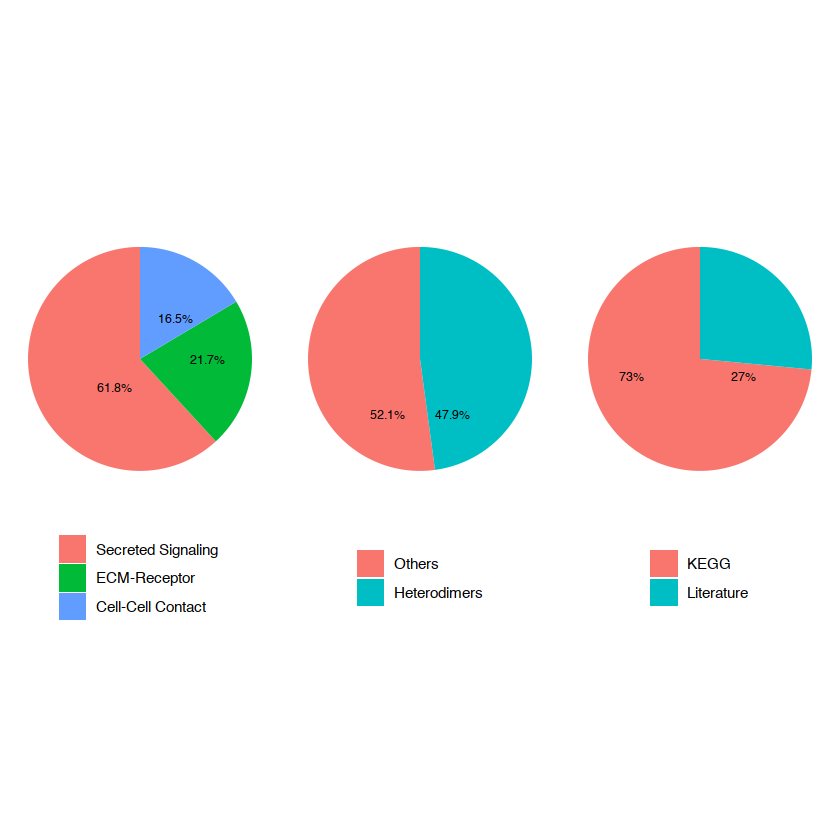

In [21]:
# Visualize content:
showDatabaseCategory(CellChatDB)

**QUESTION: What are the slots contained in the DB?**

**QUESTION: Which signaling pathways are the ones with the highest number of ligand-receptor pairs? How many LR pairs has each of them?**

- For personalizing your own DB, you can use these instructions: https://htmlpreview.github.io/?https://github.com/sqjin/CellChat/blob/master/tutorial/Update-CellChatDB.html
- Other lists of available LR pairs can be found here: https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs

**Let's add the list of LR pairs into the cellchat object**

In [29]:
cellchat@DB <- CellChatDB

## Filter the expression matrix given the list of LR pairs (step 4)

In [45]:
cellchat <- subsetData(cellchat)
# Alternative we can use a subset of LR pairs with for example:
# subsetData(cellchat, search = "Secreted Signaling")

## Compute communication scores for LR pairs & overall scores for cell-cell pairs (step 5)

Before computing the score, we need to detect over-expressed ligands and receptors

In [48]:
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)

CellChat offers a smoothing method for the gene expression, which can help improve the analysis. If used, specify ```smooth = TRUE```

In [51]:
smooth = TRUE

if (smooth){
    cellchat <- projectData(cellchat, PPI.human)
}

Compute the communication scores

In [53]:
cellchat <- computeCommunProb(object = cellchat, raw.use = not(smooth)) # LR pairs

In [54]:
cellchat <- computeCommunProbPathway(object = cellchat) # Pathways

Compute the overall scores

In [55]:
cellchat <- aggregateNet(cellchat)

Compute centrality measures given overall scores

In [ ]:
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

## Visualizations and result interpretation (step 6)

Visualizations usually involves different kind of plots, previously reviewed here: https://www.nature.com/articles/s41576-020-00292-x

![plot](./Visualizations.png)

Significant interactions (LR pairs)

Comparing communications on a single object 




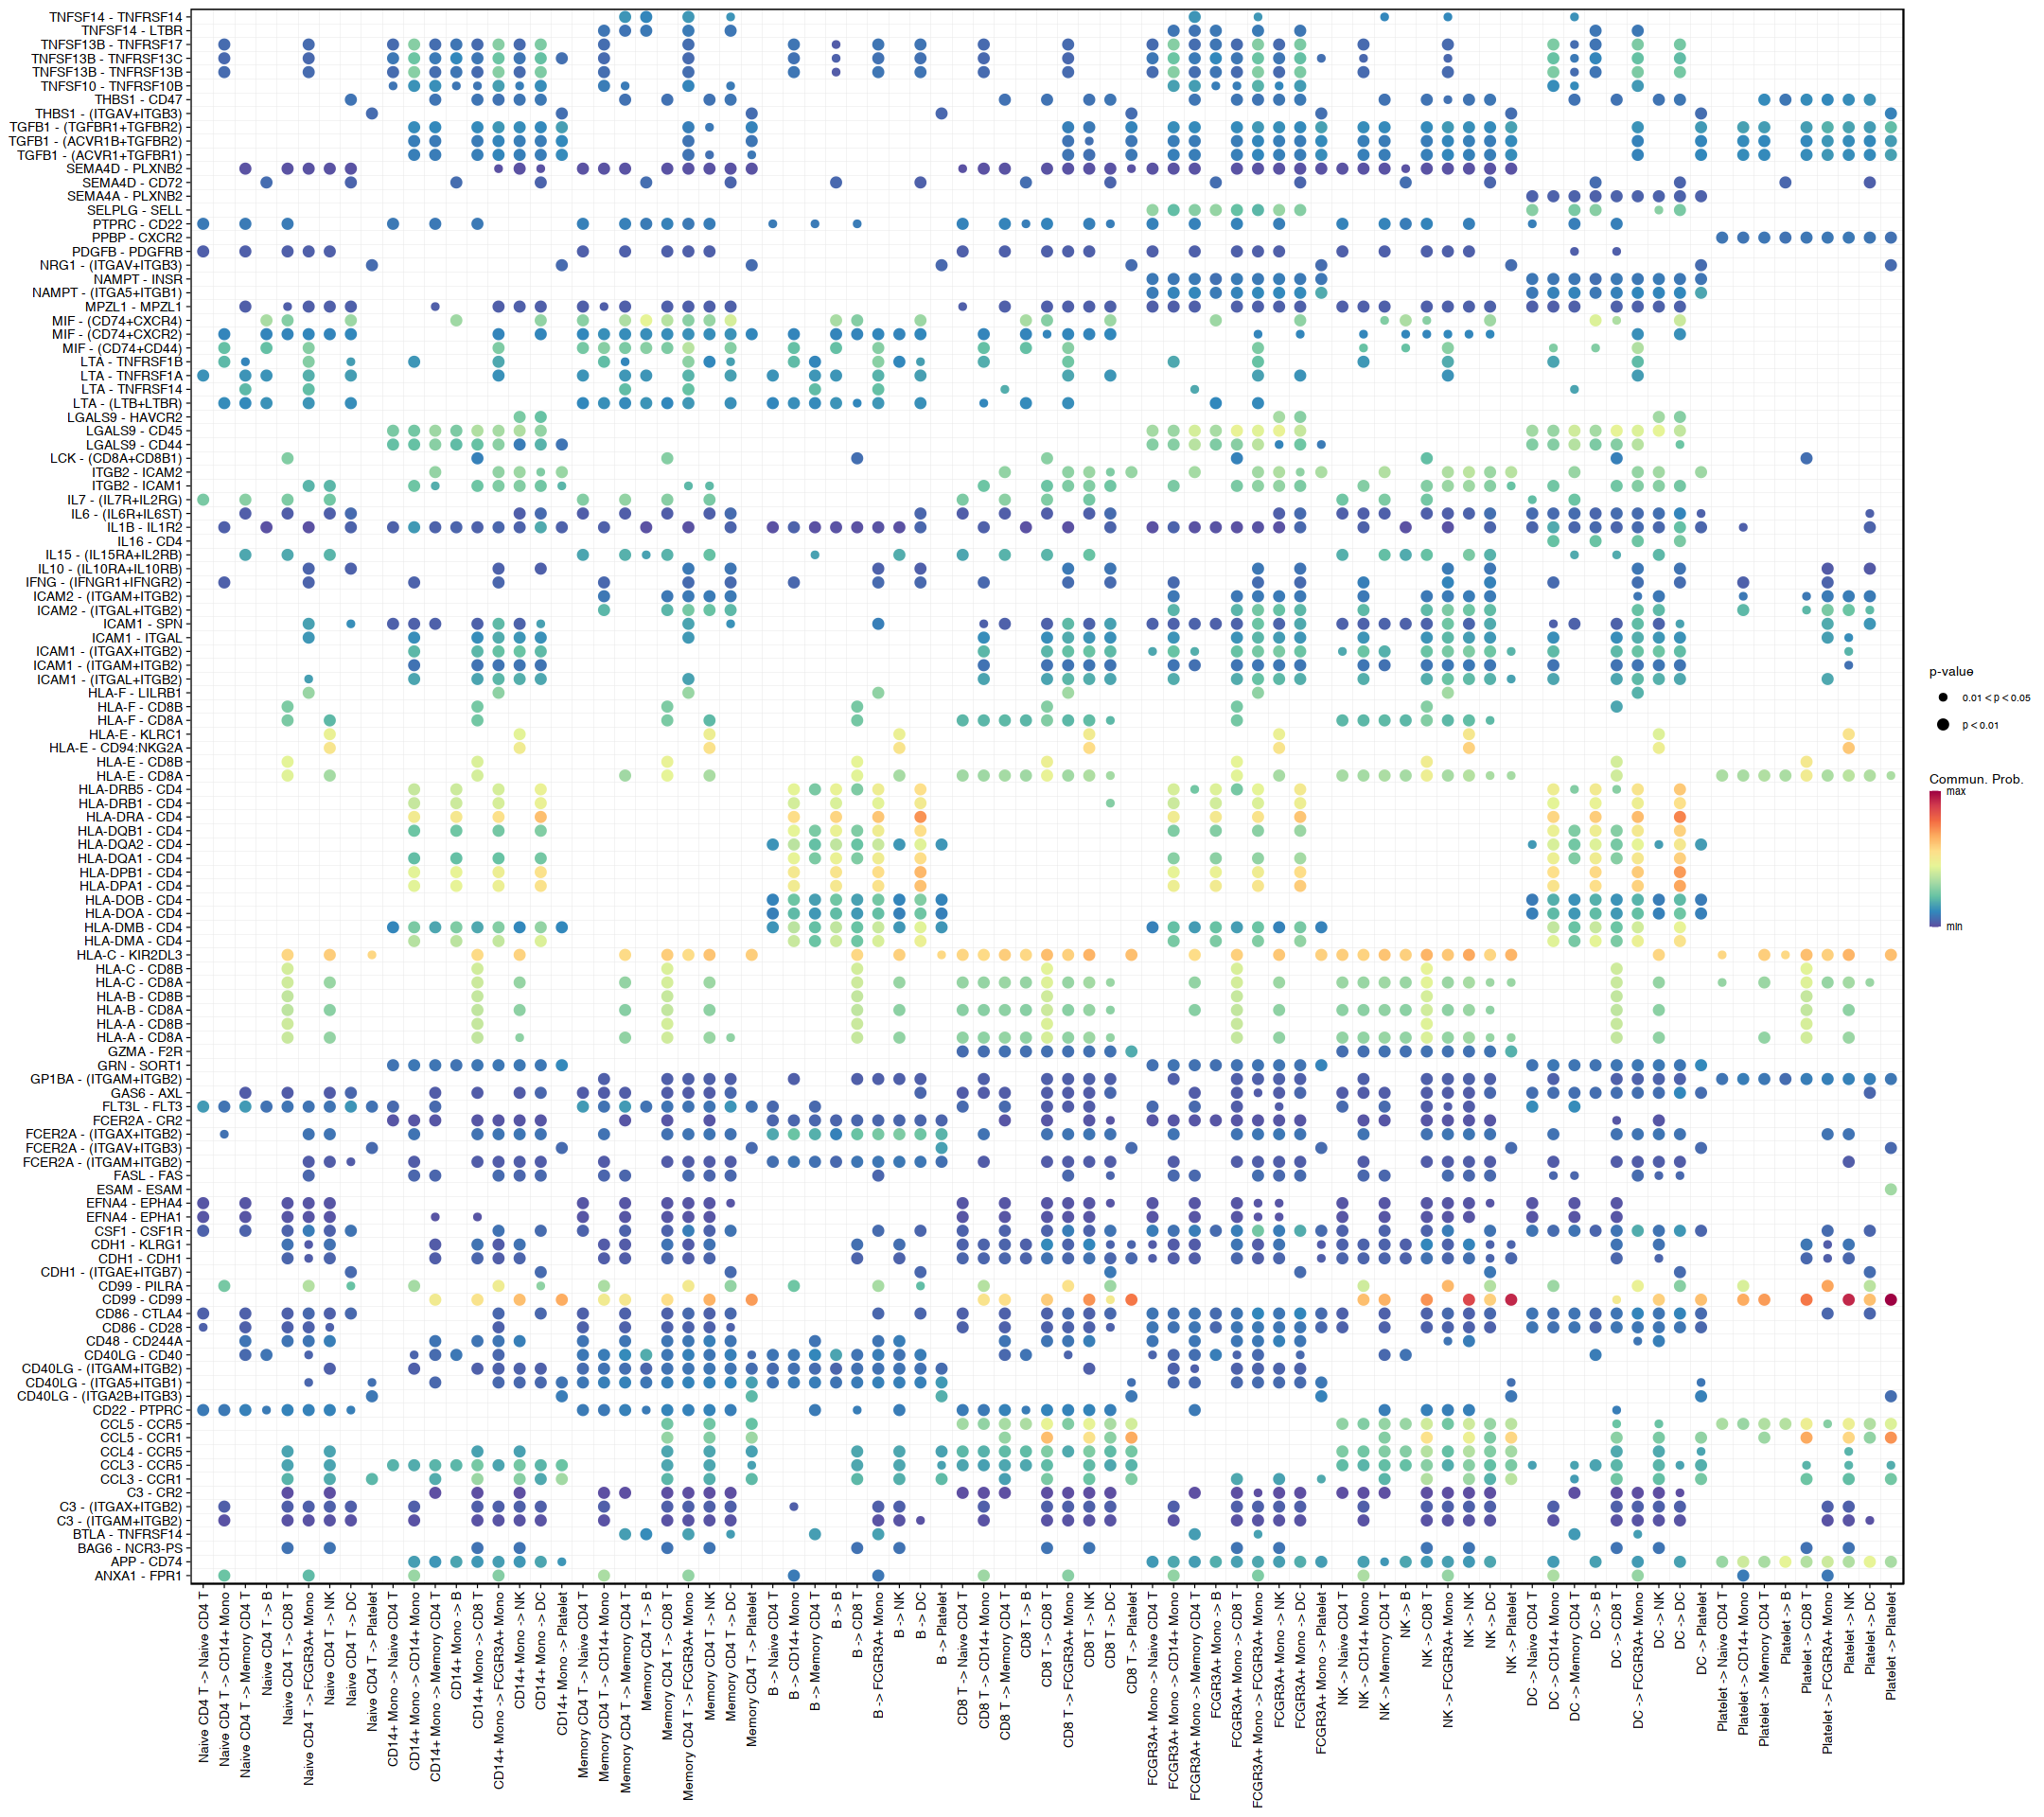

In [86]:
options(repr.plot.height = 16, repr.plot.width = 18)
netVisual_bubble(cellchat, remove.isolate = FALSE)

Significant interactions (LR pairs), but for specific cell groups

In [90]:
levels(cellchat@idents)

[1] "Naive CD4 T"  "CD14+ Mono"   "Memory CD4 T" "B"            "CD8 T"       
[6] "FCGR3A+ Mono" "NK"           "DC"           "Platelet"

Comparing communications on a single object 




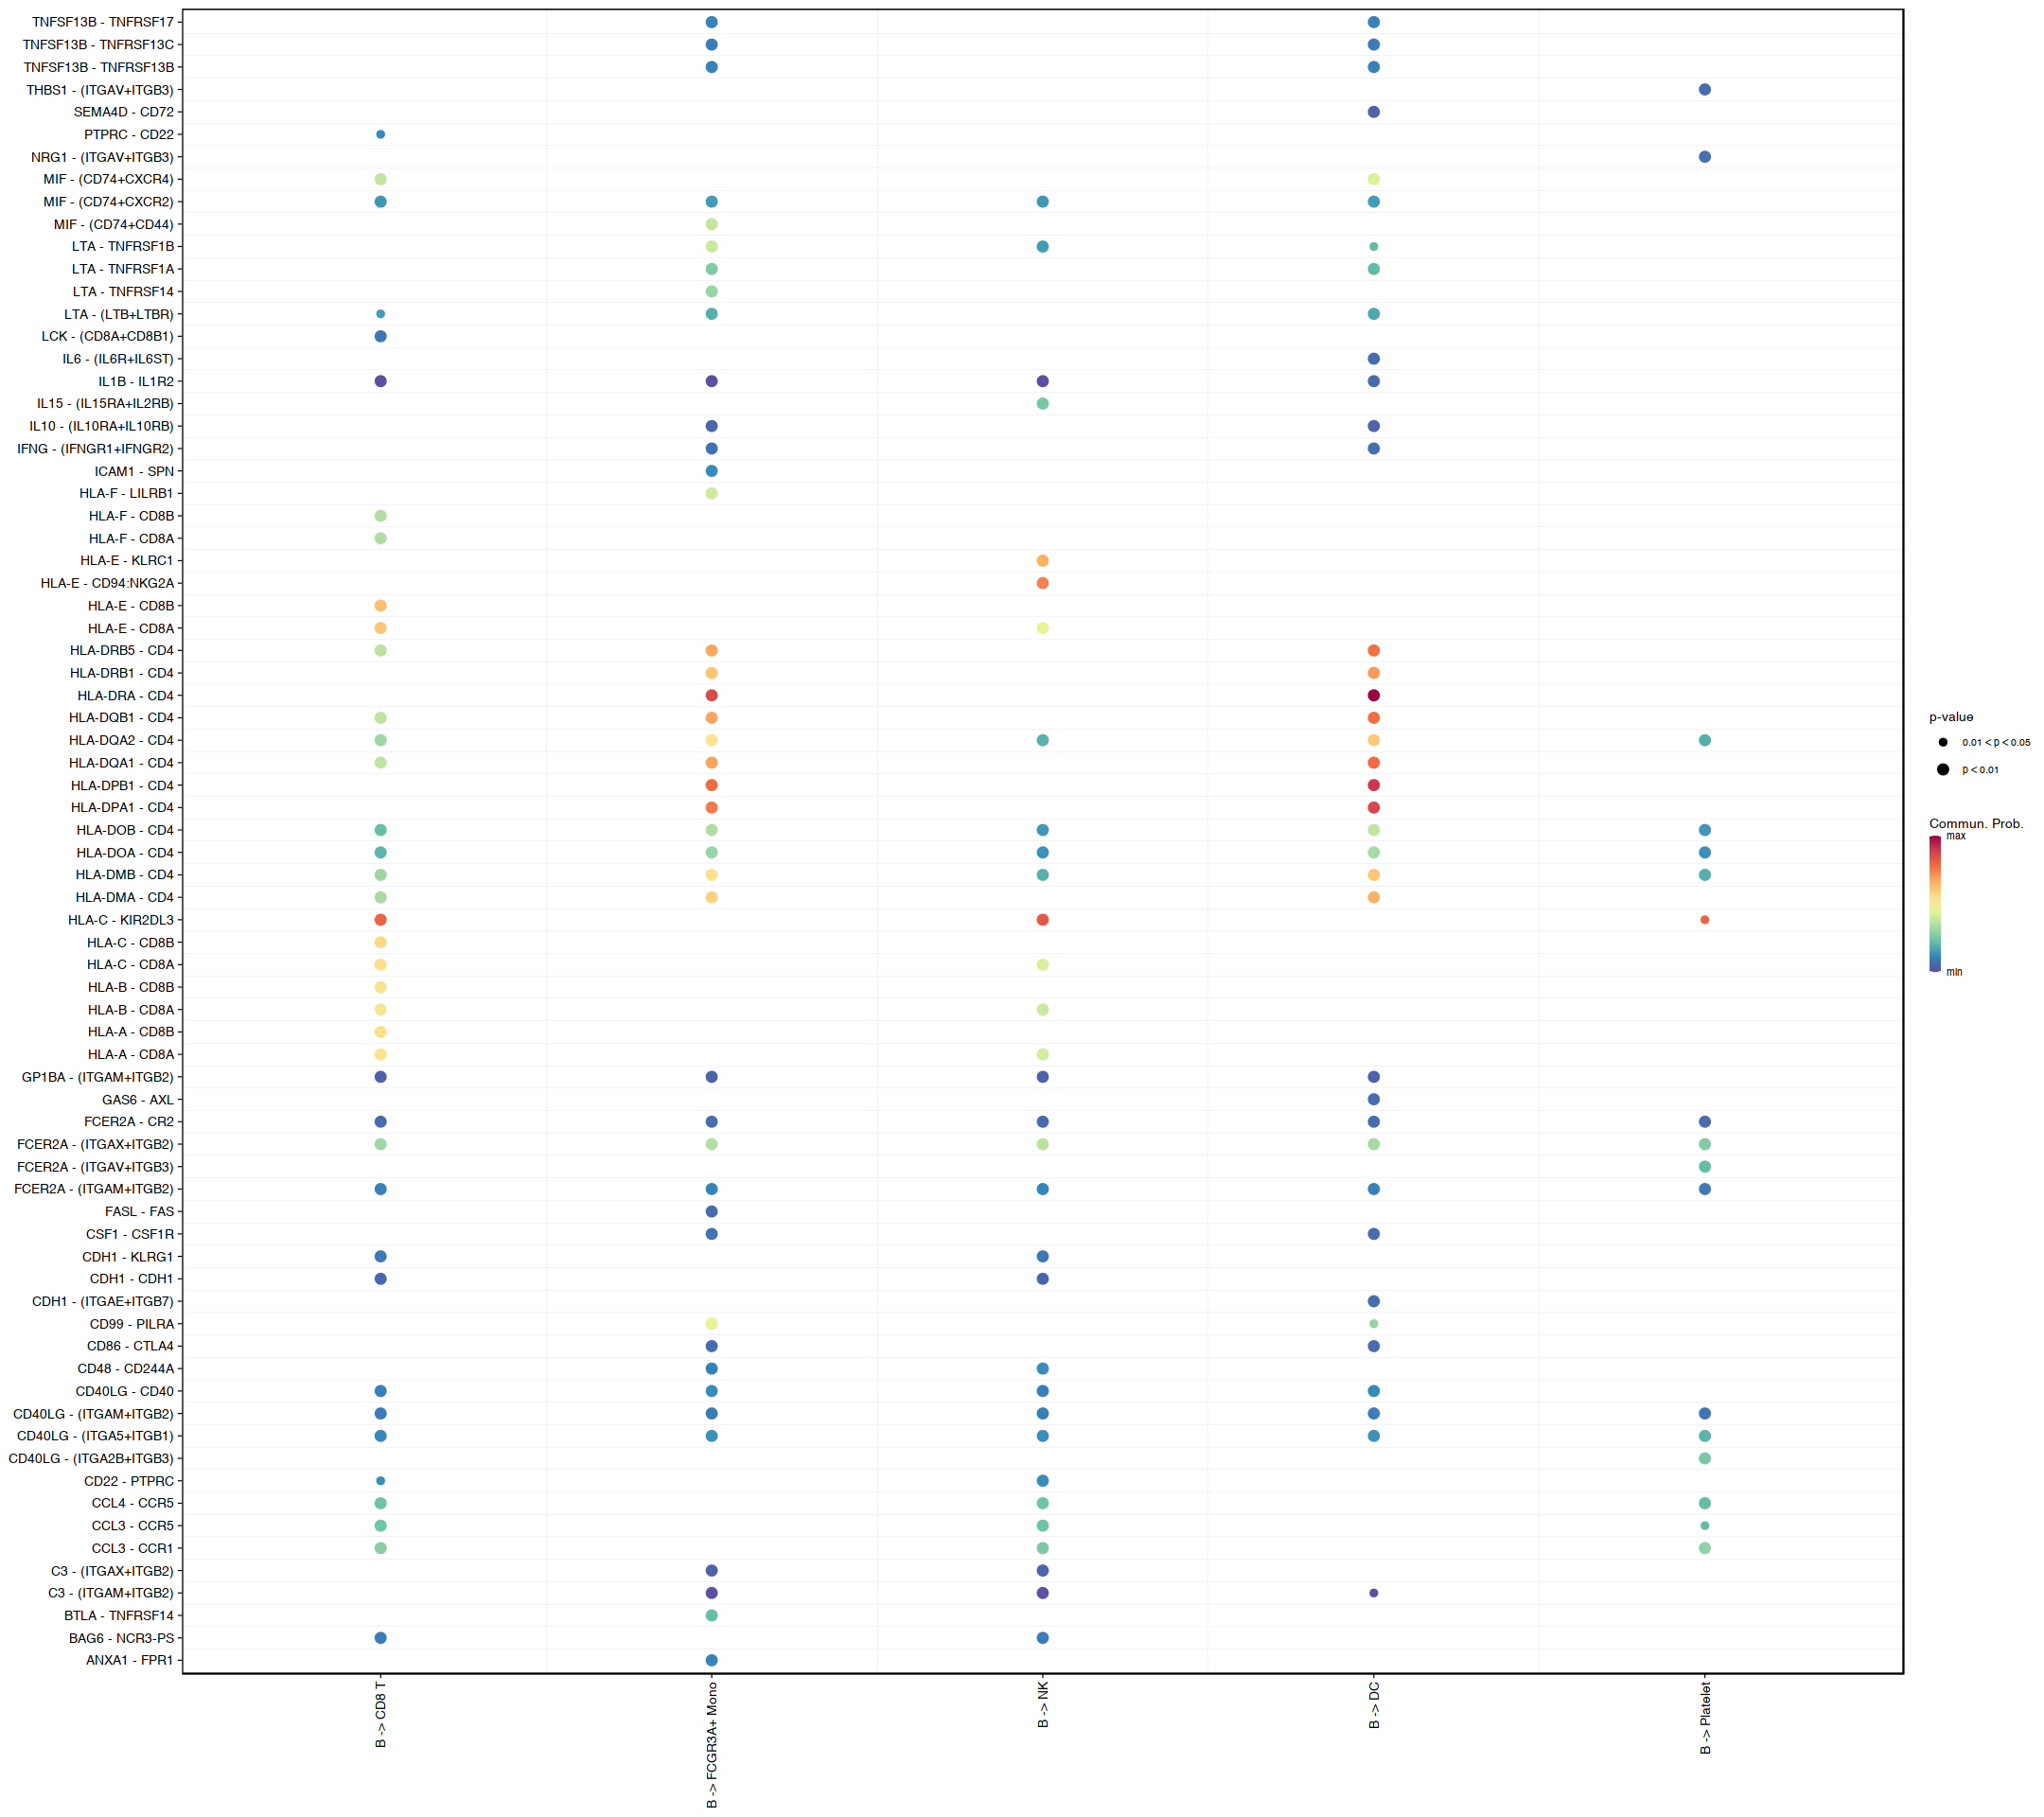

In [88]:
options(repr.plot.height = 16, repr.plot.width = 18)
netVisual_bubble(cellchat, sources.use = 4, targets.use = c(5:9), remove.isolate = FALSE)

Look into a specific pathway. **E.g. CCL**

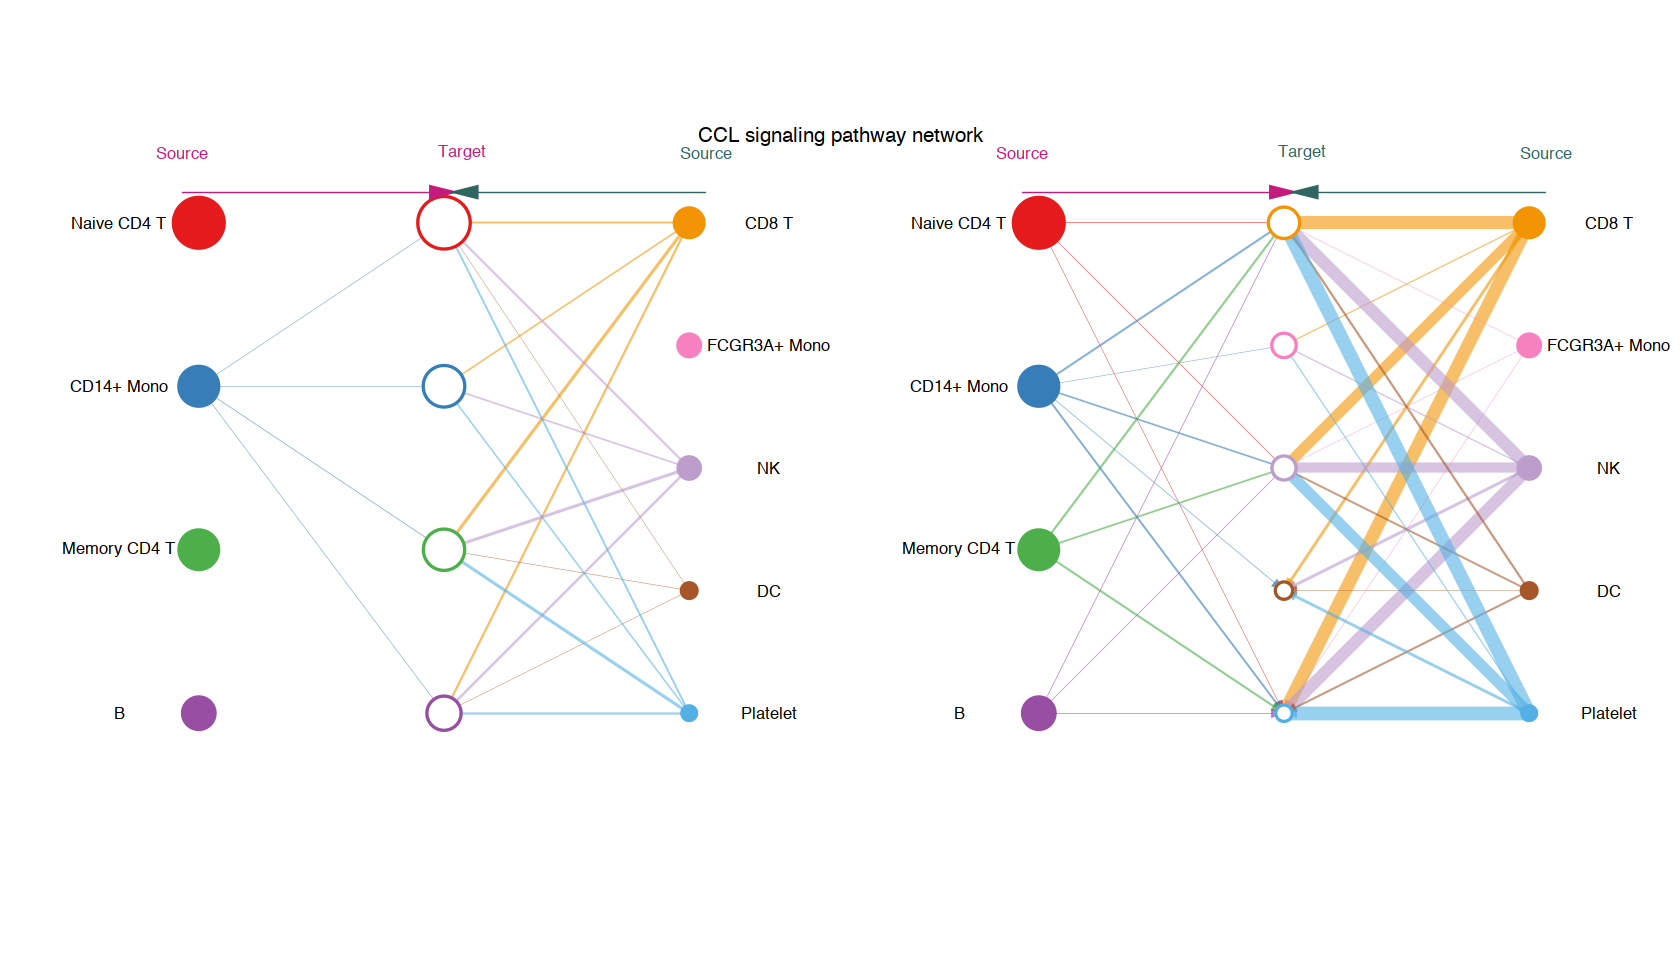

In [68]:
pathways.show <- c("CCL") 
# Hierarchy plot
options(repr.plot.height = 8, repr.plot.width = 14)
vertex.receiver = seq(1,4) # a numeric vector. 
p <- netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)

Do heatmap based on a single object 




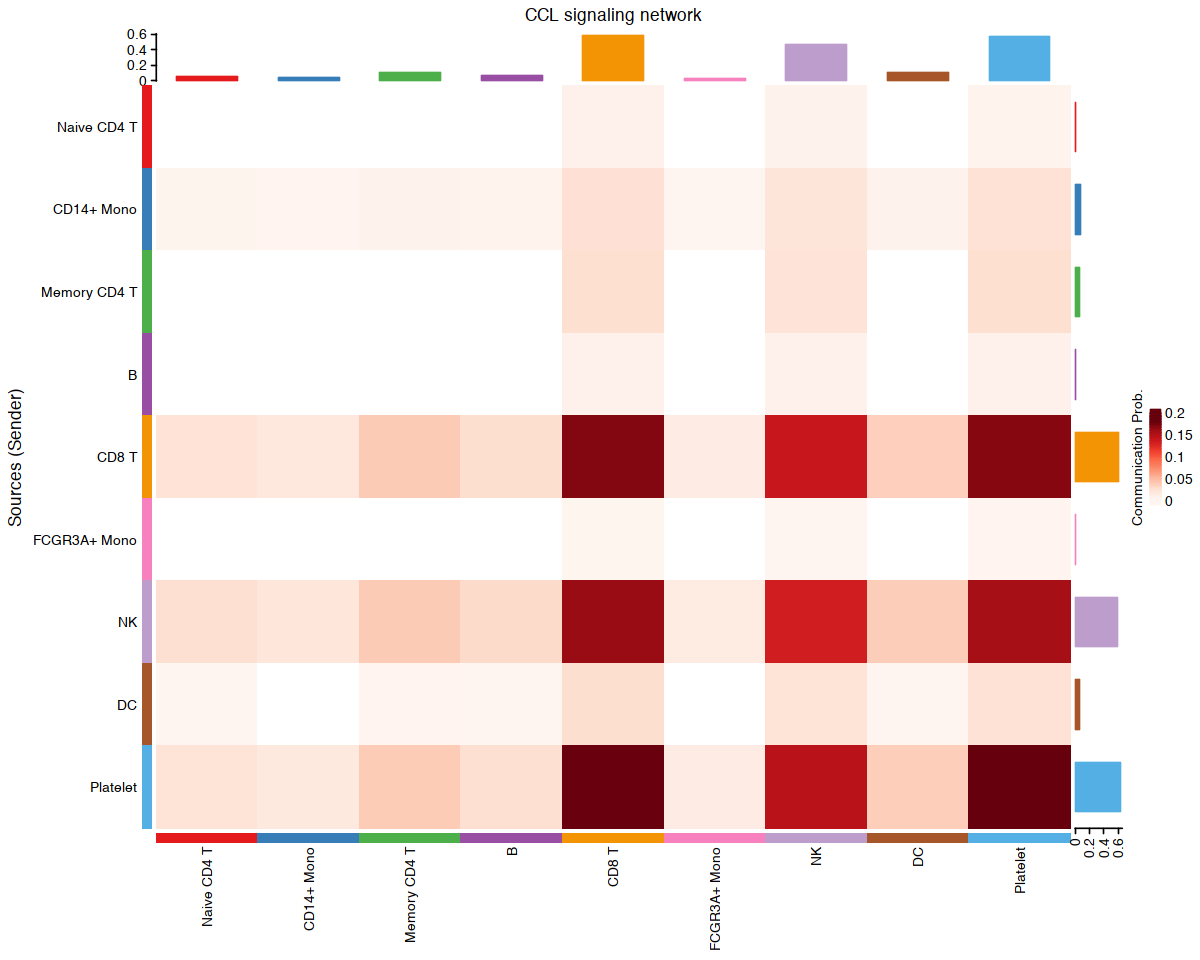

In [123]:
# Heatmap
options(repr.plot.height = 8, repr.plot.width = 10)
par(mfrow=c(1,1))
netVisual_heatmap(cellchat, signaling = pathways.show, color.heatmap = "Reds")

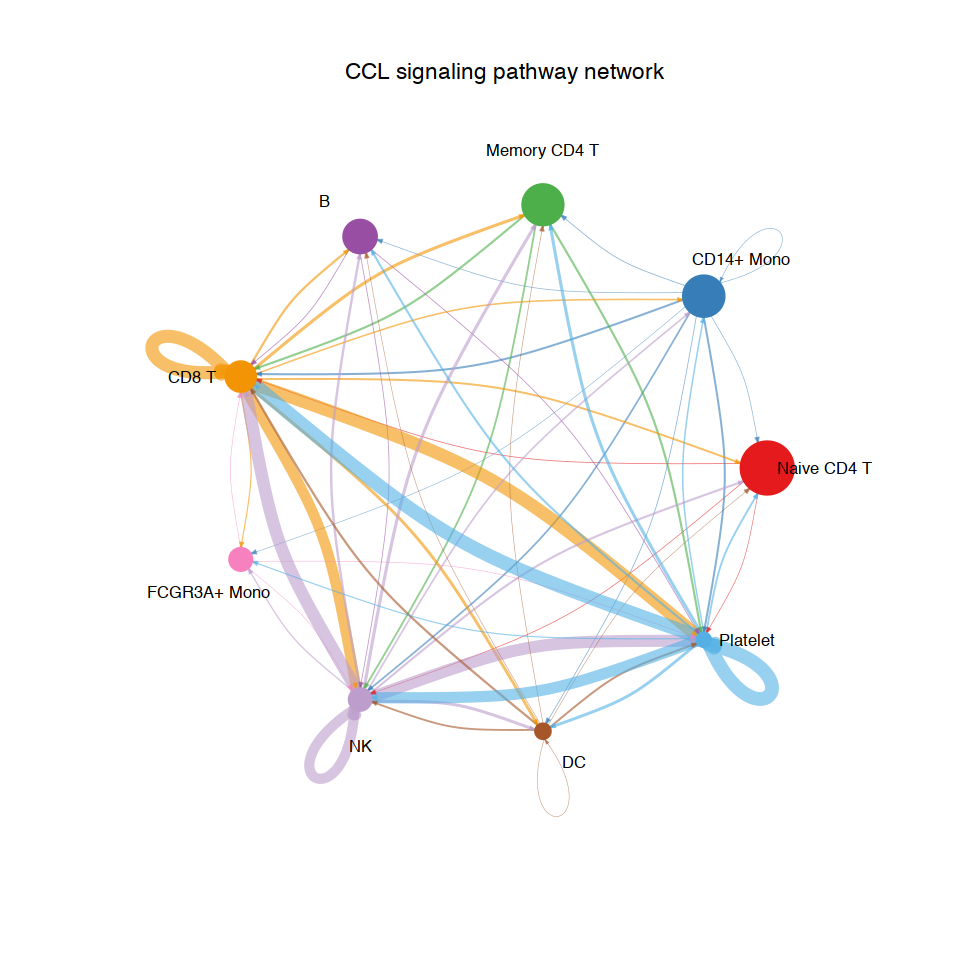

In [69]:
# Circle plot
options(repr.plot.height = 8, repr.plot.width = 8)
par(mfrow=c(1,1))
p <- netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")

Note: The second link end is drawn out of sector 'B'.

Note: The second link end is drawn out of sector 'NK'.

Note: The second link end is drawn out of sector 'Platelet'.



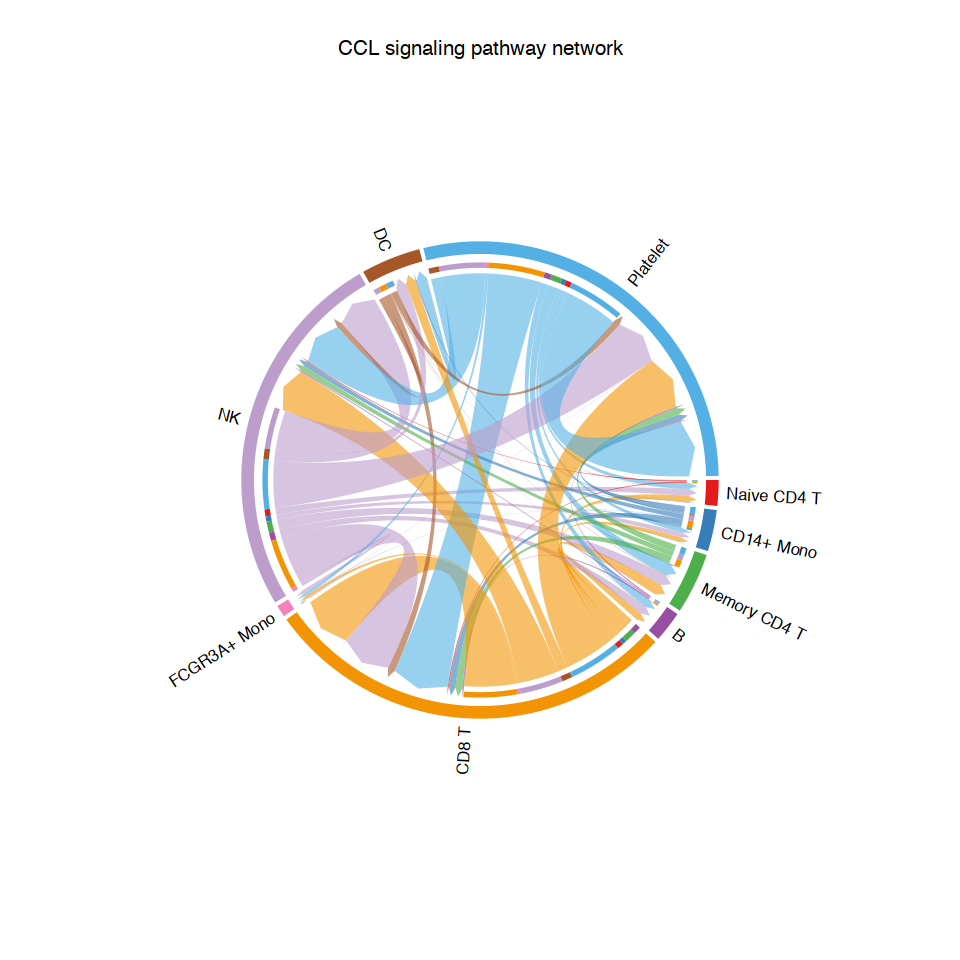

In [71]:
# Chord diagram
options(repr.plot.height = 8, repr.plot.width = 8)
par(mfrow=c(1,1))
p <- netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")

Contribution of each LR pair to the pathway

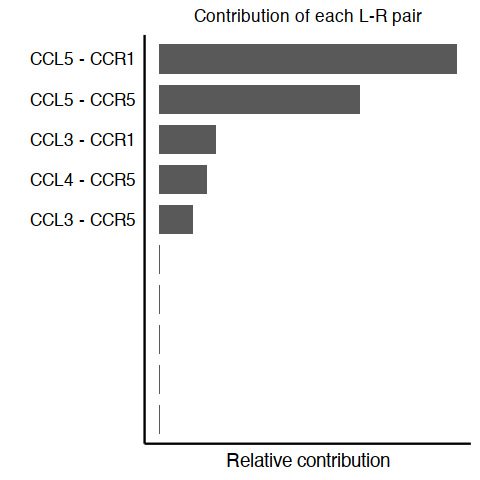

In [77]:
options(repr.plot.height = 4, repr.plot.width = 4)
netAnalysis_contribution(cellchat, signaling = pathways.show)

Network of overall communication

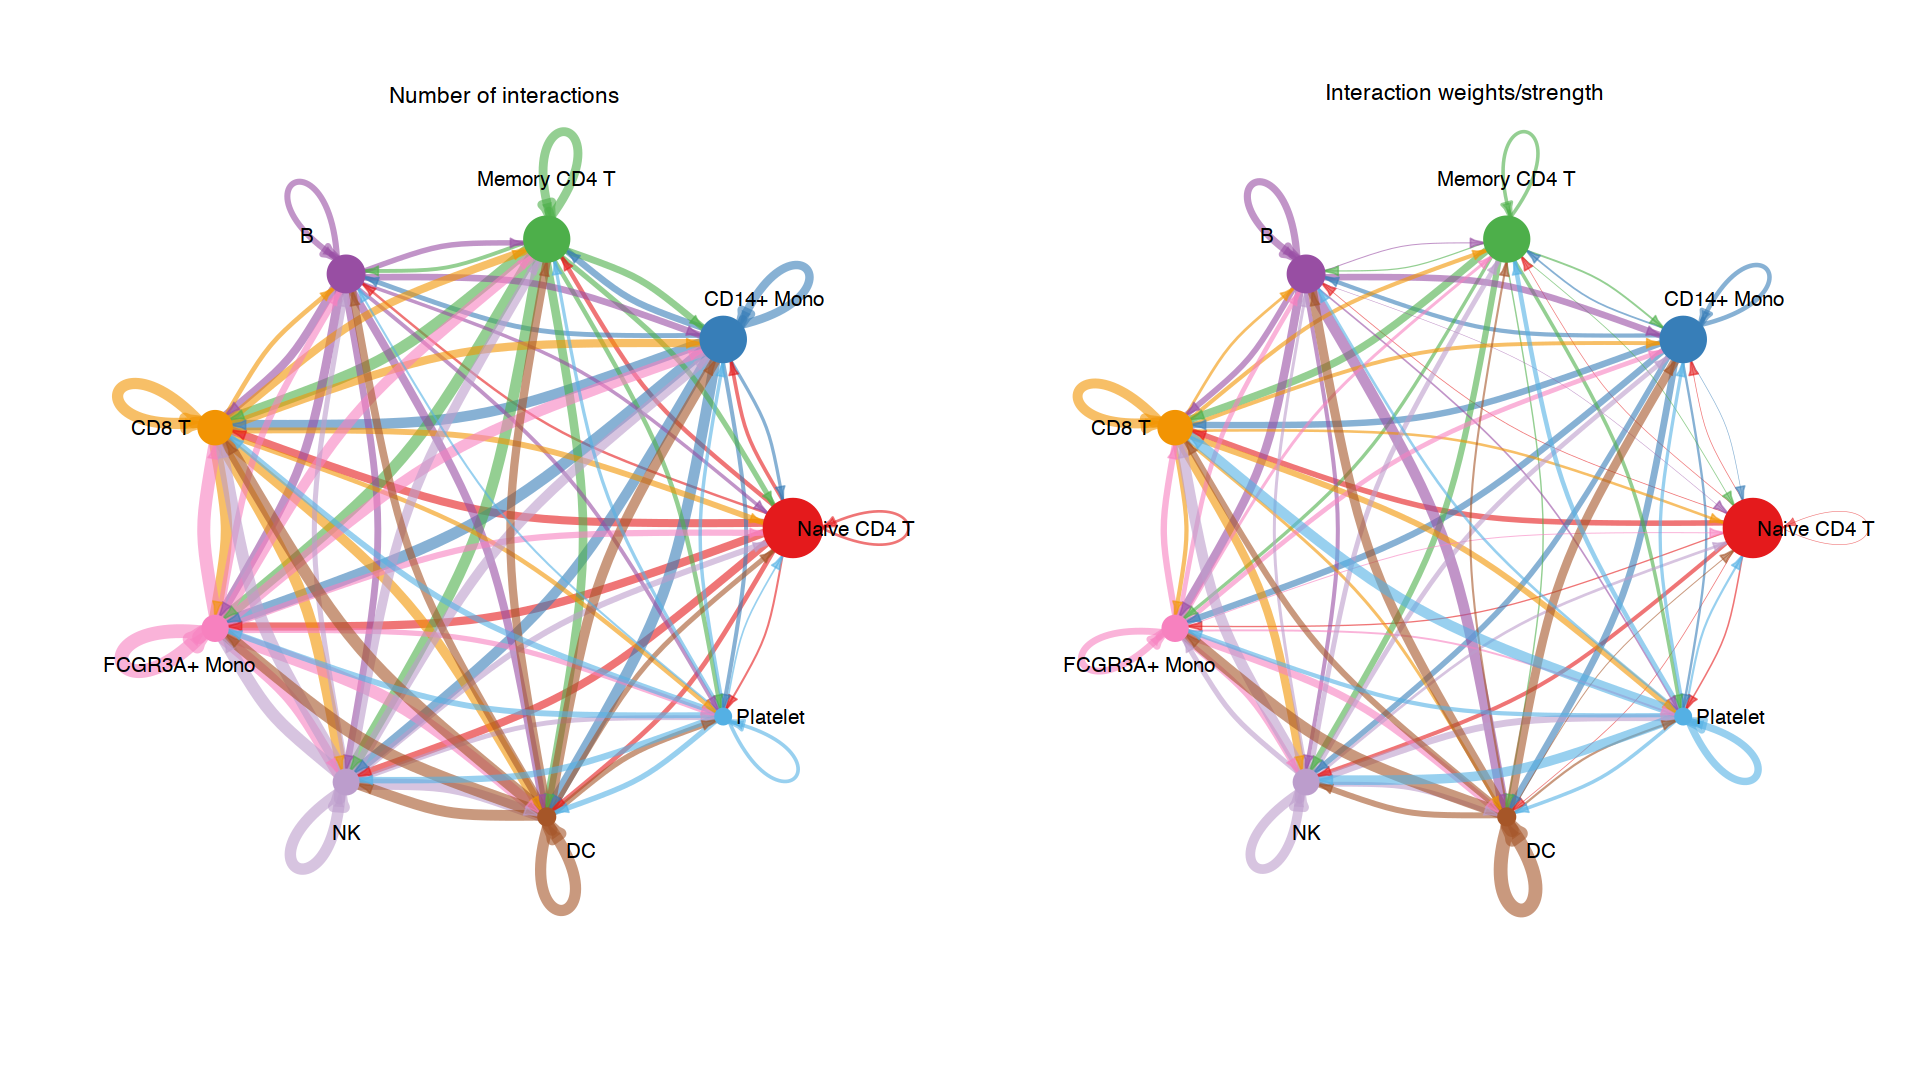

In [61]:
groupSize <- as.numeric(table(cellchat@idents))
options(repr.plot.height = 9, repr.plot.width = 16)
par(mfrow = c(1,2), xpd=TRUE)
p1 <- netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
p2 <- netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

For more analyses and other visualization approaches see the official documentation of CellChat:
https://htmlpreview.github.io/?https://github.com/sqjin/CellChat/blob/master/tutorial/CellChat-vignette.html

## Export CellChat object

In [91]:
saveRDS(cellchat, file = "cellchat_pbmc3k.rds")